# Callback merupakan package untuk mechine menentukan sendiri di epoch keberapa mechine harus berhenti guna mengambil model yang bagus

In [1]:
from jcopdl.callback import Callback,set_config

In [2]:
import torch

### package untuk mempermudah load data image

* format atau path datanya harus sesuai dengan -> data/train atau test/nama tiap feature data/ feature keberapa
* di torchvision class datasets fungsi ImageFolder

In [3]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("data/jansen_kemiskinan.csv")
df

,tahun_10,tahun_11,tahun_12,tahun_13,target_14
0,41.3,34.96,35.25,40.11,38.82
1,62.4,52.82,53.01,54.18,52.39
2,32.5,27.51,27.68,29.60,29.40
3,72.3,61.20,61.75,68.58,67.61
4,75.0,63.58,63.85,64.02,61.07
5,16.5,13.97,14.11,13.72,13.62
6,38.2,32.34,32.66,32.46,32.29
7,36.7,31.07,31.26,34.71,33.52
8,44.4,37.59,38.28,43.55,42.67
9,51.7,43.77,44.02,47.47,46.07


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe

In [7]:
X = df.drop(columns="target_14")
y=df.target_14.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9, 4), (3, 4), (9,), (3,))

In [8]:
preprocessing= ColumnTransformer([
    ("numerik", num_pipe(), X_train.columns)
])

In [9]:
X_train= preprocessing.fit_transform(X_train)
X_test= preprocessing.transform(X_test)

In [10]:
X_train= torch.FloatTensor(X_train).to(device)
X_test= torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test= torch.FloatTensor(y_test).to(device)

# Dataset dan Dataloader

In [11]:
from torchvision import datasets,transforms

In [12]:
from torch.utils.data import DataLoader,TensorDataset

In [13]:
train_set= TensorDataset(X_train,y_train)
train_loader= DataLoader(train_set,batch_size=4, shuffle=True)
test_set= TensorDataset(X_test,y_test)
test_loader= DataLoader(test_set,batch_size=4)

In [14]:
feature, target= next(iter(train_loader))

# setelah di load menjadi dataloader, kan ini data image, maka perlu penganan dijadiin tensor, karna tiap pixel gambar itu masih dalam bentuk array
* gunakan package transforms dari torchvision

In [15]:
transform= transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [16]:
train_set

In [17]:
feature,target = next(iter(train_loader))

In [19]:
label2cat= train_set.cla

AttributeError: 'TensorDataset' object has no attribute 'clases'

# Arsitektur

In [20]:
from torch import nn

#### input nya 784 karena data gambar kita dengan  ukuran pixel 28*28 dilakukan flatten jadi nya 784

In [21]:
nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 10),
    nn.LogSoftmax(1)
)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax()
)

## kita bisa menggunakan code orang lain guna meringkas dan mengurangi DRY (Don't Repeat Yourself)

In [22]:
from jcopdl.layers import linear_block

In [23]:
from torch import optim

In [28]:
nn.Sequential(
    linear_block(784,256,dropout=0.3),
    linear_block(256,64, dropout=0.3),
    linear_block(64, 10, activation='lsoftmax')
    
)

## kita buat class agar mempermudah dan mengurangi DRY dalam langkah Training Preparation (model), nanti kita bisa langsung panggil aja dan bisa kita buat custom arsitektur dalam menangani proyek seperti multitask learning

* inheritance dari class nn.Module

In [33]:
class Fashion (nn.Module):
    def __init__ (self, input_size, n_neuron1, n_neuron2, out_size, dropout):
        super(). __init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size,n_neuron1, dropout=dropout),
            linear_block(n_neuron1,n_neuron2 ,dropout=dropout),
            linear_block(n_neuron2,out_size)
        )
    def forward (self, x):
        return self.model(x)

# Training Preparation -> MCOC

In [34]:
model= Fashion(4,10,15,1,0)

In [35]:
criterion= nn.MSELoss()

In [36]:
from torch import optim

In [37]:
optimizer= optim.AdamW(model.parameters(), lr=0.001)

### ada tahapan tambahan sebelum masuk training preparation, "config" untuk menyimpan beberapa informasi untuk model kita

In [40]:
config= set_config({
    "input_size" : 4,
    "n_neuron1" : 10,
    "n_neuron2" : 15,
    "output_size" :1,
    "dropout": 0
})

In [39]:
config.output_size

1

In [41]:
model= Fashion(config.input_size, config.n_neuron1, config.n_neuron2, config.output_size,config.dropout)

In [42]:
criterion= nn.MSELoss()

In [43]:
optimizer= optim.AdamW(model.parameters(), lr=0.001)

#### Callback merupakan package untuk mechine menentukan sendiri di epoch keberapa mechine harus berhenti guna mengambil model yang bagus

In [44]:
from jcopdl.callback import Callback

In [45]:
callback= Callback(model,config,outdir="model_kemiskinan")

* early_stop_patience ini lah yang membuat model kita akan berhenti epoch nya jika cost atau accuracy (tergantung apa yang mau dimonitor) mulai jelek daripada epoch sebelum nya.

In [46]:
from tqdm.auto import tqdm

In [47]:
def loop_fn(mode, dataset, dataloader, model, creterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost=0
    for feature,target in tqdm(dataloader,desc = mode.title()):
        feature,target= feature.to(device),target.to(device)
        output= model(feature)
        loss= criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost+=loss.item()*feature.shape[0]
        
    cost= cost/len(dataset)
    
    return cost

In [56]:
while True:
    train_cost, train_score = loop_fn("train",train_set,train_loader,model,criterion,optimizer,device) 
    with torch.no_grad():
        test_cost,test_score= loop_fn("test",test_set,test_loader,model,criterion,optimizer,device) 
        
    callback.log(train_cost,test_cost,train_score,test_score)
    
    callback.save_checkpoint()
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

C:\Users\Rahmat\anaconda3\envs\jcop\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Rahmat\anaconda3\envs\jcop\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TypeError: cannot unpack non-iterable float object

In [30]:
import matplotlib.pyplot as plt

In [42]:
feature,target= next(iter(test_loader))
feature, target = feature.to(device), target.to(device)

In [43]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    pred = output.argmax(1)
pred

tensor([0, 1, 1, 9, 4, 3, 3, 5, 7, 7, 8, 5, 3, 3, 0, 3, 1, 2, 9, 2, 5, 7, 5, 8,
        8, 2, 4, 1, 3, 8, 2, 1, 5, 1, 2, 3, 3, 4, 9, 9, 5, 2, 3, 7, 5, 4, 4, 0,
        2, 3, 6, 4, 9, 7, 7, 7, 8, 2, 6, 7, 5, 9, 0, 4, 6, 0, 3, 2, 1, 6, 6, 5,
        1, 6, 0, 1, 6, 3, 5, 3, 4, 5, 4, 4, 1, 8, 3, 3, 5, 6, 5, 4, 4, 0, 9, 4,
        2, 1, 7, 2, 4, 0, 8, 0, 6, 1, 9, 0, 3, 8, 3, 2, 7, 1, 7, 4, 7, 9, 4, 5,
        3, 6, 6, 5, 0, 2, 1, 8])

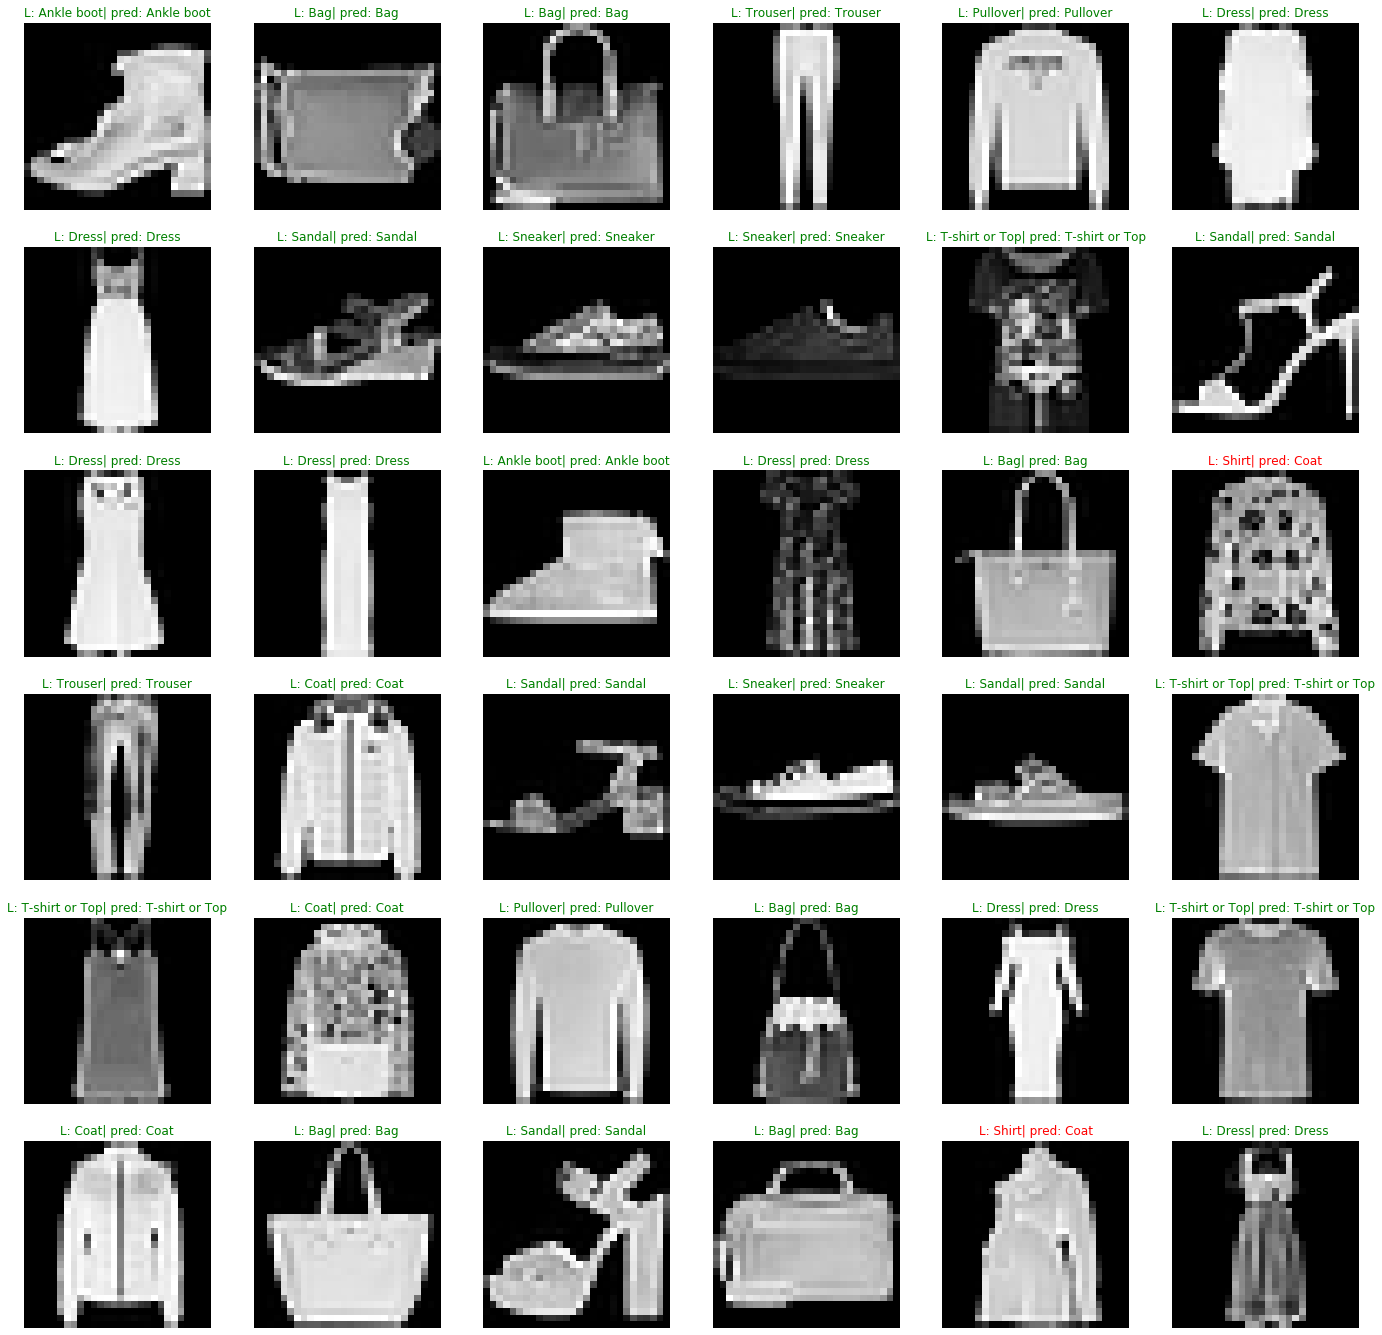

In [44]:
fig, axes= plt.subplots(6, 6, figsize= (24, 24))
for img, label,pred, ax in zip(feature, target, pred,axes.flatten()):
    ax.imshow(img.view(28,28).cpu(), cmap='gray')
    font = {"color":"r"} if label != pred else {"color" :"g"}
    label,pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label}| pred: {pred}",fontdict=font);
    ax.axis("off");